In [2]:
%load_ext autoreload
%autoreload 2  

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import functions as f

from sklearn.tree import DecisionTreeRegressor
# from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import mean_squared_error
import warnings 

warnings.filterwarnings('ignore')

In [33]:
ticker = 'PETR4.SA'
start_date = '2015-01-01'
end_date = '2023-12-31'
df = yf.download(ticker, start=start_date, end=end_date)['Adj Close']

[*********************100%***********************]  1 of 1 completed


,Adj Close,Returns,Target,MA
Date,,,,
2015-01-08,3.397466,0.064591,0.030336,3.246550
2015-01-09,3.500531,0.030336,-0.070452,3.257592
2015-01-12,3.253912,-0.070452,0.028280,3.278206
2015-01-13,3.345935,0.028280,-0.019802,3.337836
2015-01-14,3.279678,-0.019802,0.044893,3.355505
...,...,...,...,...
2023-07-20,29.129999,0.001031,0.018881,29.020000
2023-07-21,29.680000,0.018881,0.020889,29.146000
2023-07-24,30.299999,0.020889,0.023102,29.408000


In [122]:
def two_one_trading(precos, periodo, media_movel):
    precos = pd.DataFrame(precos)
    periodo = periodo
    media_movel = media_movel
    
    def transform_df(df, start, end, vars=['bull', 'bear'], target=['Target']):
        df['Returns'] = df['Adj Close'].pct_change(1)
        df['Target'] = df['Adj Close'].pct_change(periodo).shift(-periodo) 
        df['MA'] = df['Adj Close'].rolling(media_movel).mean()
        df = df[['Adj Close', 'Returns', 'Target', 'MA']].dropna()
        df['bull'] = np.where(((df['Returns'].shift(2) < 0) & (df['Returns'].shift(1) < 0) & (df['Returns'] > 0)), 1, 0)
        df['bear'] = np.where(((df['Returns'].shift(2) > 0) & (df['Returns'].shift(1) > 0) & (df['Returns'] < 0)), 1, 0)
        df = df.loc[start:end]
        return df

    start_train = df.index.min()
    end_train = '2020-12-31'
    df_train = transform_df(precos, start=start_train, end=end_train)

    start_oot = '2021-01-01'
    end_oot = df.index.max()
    df_oot = transform_df(precos, start=start_oot, end=end_oot)

    vars = ['bull', 'bear']

    X_train = df_train[vars]
    y_train = df_train['Target']

    X_oot = df_oot[vars]
    y_oot = df_oot['Target']
    
    # Instancia o modelo
    model = DecisionTreeRegressor(random_state=123)

    # Treina o modelo
    model.fit(X_train, y_train)

    # Cria o Predict
    y_pred_train = model.predict(X_train)
    y_pred = model.predict(X_oot)

    # Mean Squared Error
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_oot = mean_squared_error(y_oot, y_pred)
    print(f'MSE treino: {mse_train}')
    print(f'MSE out-of-time: {mse_oot}')
    
    print(f'{mse_oot/mse_train}')

    df_oot
    
    df_oot['preds'] = model.predict(df_oot[['bull', 'bear']])

    custos = 0.001

    df_oot['retorno_preds'] = np.where(((df_oot['preds'] > np.mean(y_pred)) & (df_oot['Adj Close']/df_oot['MA'] < 0.99))
                                , df_oot['Target'] - custos
                                , np.where(((df_oot['preds'] < np.mean(y_pred)) & (df_oot['Adj Close']/df_oot['MA'] >1.01))
                                , -df_oot['Target'] - custos
                                , 0 
                                    ))

    df_oot['retorno_preds_acumulado'] = df_oot['retorno_preds'].cumsum()
    
    print(f'resultado financeiro: {df_oot["retorno_preds_acumulado"][-1]}')
    print(f.summary_stats(pd.DataFrame(df_oot['retorno_preds'])))
    
    return df_oot

In [123]:
periodos = [1,2,3,4,5]
ma = [1,2,3,4,5]

for p in periodos:
    for m in ma:
        print(p,m)
        print(f'{two_one_trading(df, p, m)}')
        print('--------------------------------------------------')
        

1 1
MSE treino: 0.001124977065007258
MSE out-of-time: 0.0006593642461463921
0.5861135010269193
resultado financeiro: 0.0
               Annualized Return  Annualized Vol  Sharpe Ratio  \
retorno_preds                0.0             0.0          -inf   

               Average Drawdown  Skewness  Kurtosis  Cornish-Fisher VaR (5%)  \
retorno_preds               0.0       NaN       NaN                      NaN   

               Historic CVaR (5%)  Max Drawdown  
retorno_preds                -0.0           0.0  
            Adj Close   Returns    Target         MA  bull  bear     preds  \
Date                                                                         
2021-01-04  11.470778  0.020113  0.039087  11.470778     0     0  0.001473   
2021-01-05  11.919136  0.039087  0.001997  11.919136     0     0  0.001473   
2021-01-06  11.942943  0.001997  0.029900  11.942943     0     0  0.001473   
2021-01-07  12.300040  0.029900  0.003871  12.300040     0     0  0.001473   
2021-01-08  12.34

In [124]:
df_model = two_one_trading(df, 2, 2)

MSE treino: 0.0020917359332140355
MSE out-of-time: 0.0012732976358625929
0.6087277154081875
resultado financeiro: 0.6472065286952049
               Annualized Return  Annualized Vol  Sharpe Ratio  \
retorno_preds           0.010642        0.056418     -0.334006   

               Average Drawdown  Skewness   Kurtosis  Cornish-Fisher VaR (5%)  \
retorno_preds          -0.06786  0.513502  20.497994                 0.017551   

               Historic CVaR (5%)  Max Drawdown  
retorno_preds            0.038492      -0.29633  


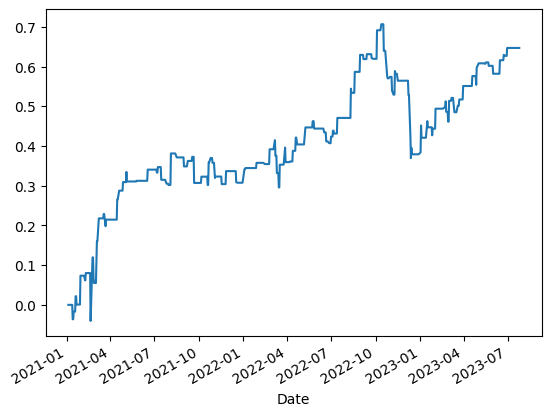

In [125]:
df_model['retorno_preds_acumulado'].plot();

In [126]:
f.summary_stats(pd.DataFrame(df_model['retorno_preds']))

,Annualized Return,Annualized Vol,Sharpe Ratio,Average Drawdown,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Max Drawdown
retorno_preds,0.010642,0.056418,-0.334006,-0.06786,0.513502,20.497994,0.017551,0.038492,-0.29633
